In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


benign_train = np.array(Dataset_loader('/content/drive/MyDrive/data/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/data/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/data/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/data/test/malignant',224))

100%|██████████| 300/300 [00:02<00:00, 106.39it/s]


In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
print("No.of Training Samples:",len(X_train))
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
print("No.of Testing Samples:",len(X_test))
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)


No.of Training Samples: 2637
No.of Testing Samples: 660


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

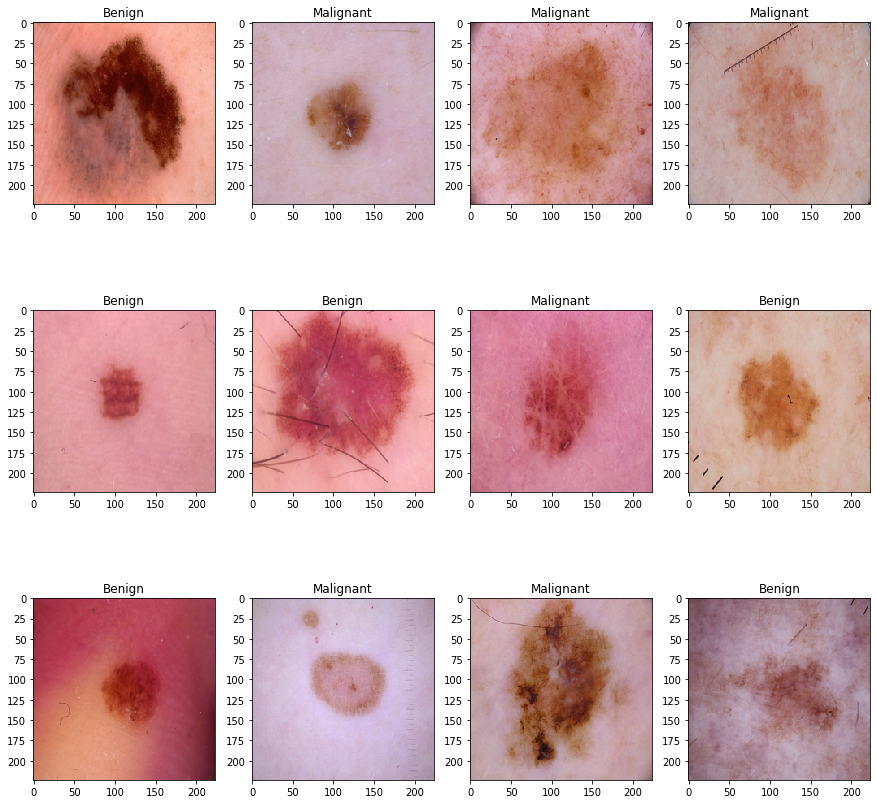

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
def gkernel(l=3, sig=2):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)


Gaussian Filter:  [[0.10186806 0.11543164 0.10186806]
 [0.11543164 0.13080118 0.11543164]
 [0.10186806 0.11543164 0.10186806]]


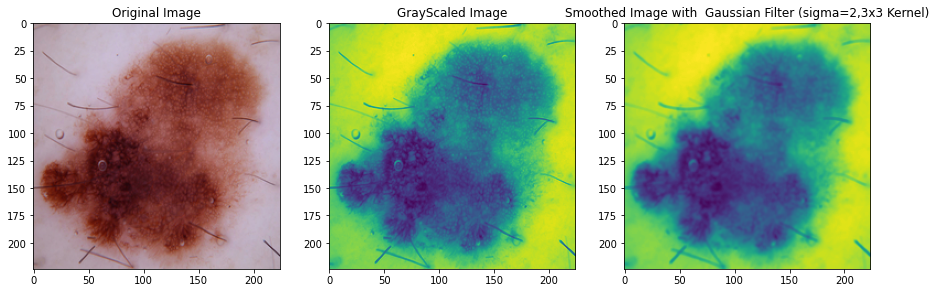

In [ ]:
img = cv2.imread('/content/drive/MyDrive/data/test/malignant/1007.jpg') 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
g_kernel = gkernel(3,2) 
print("Gaussian Filter: ",g_kernel) 
dst = cv2.filter2D(gray,-1,g_kernel) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 7))
plt.subplot(131),plt.imshow(img),plt.title('Original Image') 
plt.subplot(132),plt.imshow(gray),plt.title('GrayScaled Image')
plt.subplot(133),plt.imshow(dst),plt.title('Smoothed Image with  Gaussian Filter (sigma=2,3x3 Kernel)')
plt.show()

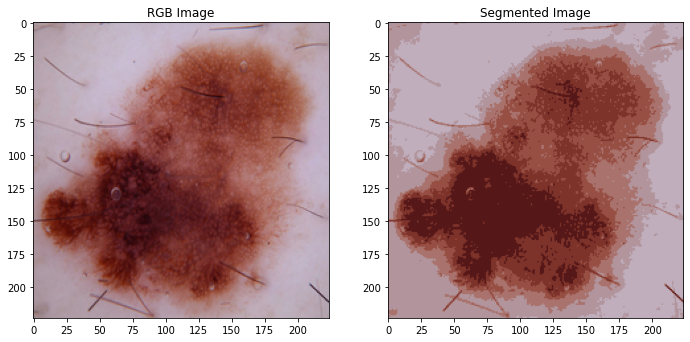

In [ ]:
image = cv2.imread('/content/drive/MyDrive/data/test/malignant/1007.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 6
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image.shape))
plt.figure(figsize=(18, 9))
plt.subplot(131),plt.imshow(image),plt.title('RGB Image') 
plt.subplot(132),plt.imshow(segmented_image),plt.title('Segmented Image')
plt.show()

In [ ]:
import cv2
image = cv2.imread("/content/drive/MyDrive/data/test/malignant/1007.jpg")
print(image)

[[[160 151 171]
  [160 151 172]
  [161 152 172]
  ...
  [178 166 184]
  [176 166 183]
  [175 163 181]]

 [[159 152 173]
  [158 153 174]
  [160 154 173]
  ...
  [177 165 183]
  [175 163 183]
  [174 161 183]]

 [[149 147 167]
  [152 147 168]
  [151 145 168]
  ...
  [177 165 185]
  [175 164 184]
  [175 163 185]]

 ...

 [[138 136 156]
  [135 135 159]
  [127 130 158]
  ...
  [172 162 178]
  [172 161 177]
  [174 161 177]]

 [[143 135 158]
  [136 130 153]
  [137 135 157]
  ...
  [176 164 184]
  [172 162 179]
  [170 158 176]]

 [[137 131 154]
  [139 138 158]
  [143 140 162]
  ...
  [174 164 181]
  [173 162 178]
  [170 159 175]]]


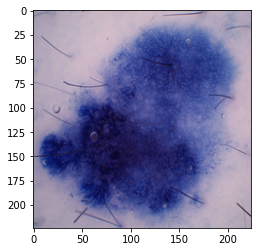

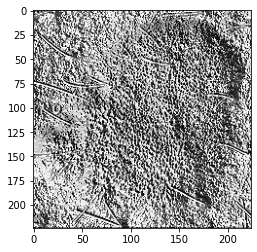

LBP Program is finished


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
def get_pixel(img, center, x, y):
	
	new_value = 0
	
	try:
		if img[x][y] >= center:
			new_value = 1
			
	except:
		pass
	
	return new_value
def lbp_calculated_pixel(img, x, y):

	center = img[x][y]

	val_ar = []
	val_ar.append(get_pixel(img, center, x-1, y-1))
	val_ar.append(get_pixel(img, center, x-1, y))
	val_ar.append(get_pixel(img, center, x-1, y + 1))
	val_ar.append(get_pixel(img, center, x, y + 1))
	val_ar.append(get_pixel(img, center, x + 1, y + 1))
	val_ar.append(get_pixel(img, center, x + 1, y))
	val_ar.append(get_pixel(img, center, x + 1, y-1))
	val_ar.append(get_pixel(img, center, x, y-1))
	power_val = [1, 2, 4, 8, 16, 32, 64, 128]

	val = 0
	
	for i in range(len(val_ar)):
		val += val_ar[i] * power_val[i]
		
	return val
path = '/content/drive/MyDrive/data/test/malignant/1007.jpg'
img_bgr = cv2.imread(path, 1)
height, width, _ = img_bgr.shape
img_gray = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)
img_lbp = np.zeros((height, width),
				np.uint8)
for i in range(0, height):
	for j in range(0, width):
		img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
plt.imshow(img_bgr)
plt.show()
plt.imshow(img_lbp, cmap ="gray")
plt.show()
print("LBP Program is finished")


In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

In [ ]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
33/32 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.7658
Epoch 1: val_accuracy improved from -inf to 0.65152, saving model to weights.best.hdf5
32/32 [==============================] - 56s 1s/step - loss: 0.5453 - accuracy: 0.7658 - val_loss: 0.6601 - val_accuracy: 0.6515 - lr: 1.0000e-04
Epoch 2/10
33/32 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8298
Epoch 2: val_accuracy improved from 0.65152 to 0.78030, saving model to weights.best.hdf5
32/32 [==============================] - 35s 1s/step - loss: 0.4010 - accuracy: 0.8298 - val_loss: 0.5021 - val_accuracy: 0.7803 - lr: 1.0000e-04
Epoch 3/10
33/32 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8497
Epoch 3: val_accuracy improved from 0.78030 to 0.83902, saving model to weights.best.hdf5
32/32 [==============================] - 36s 1s/step - loss: 0.3509 - accuracy: 0.8497 - val_loss: 0.3536 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 4/10
33

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

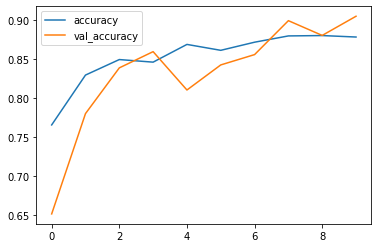

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

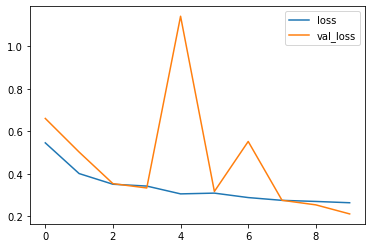

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.load_weights("weights.best.hdf5")
Y_val_pred = model.predict(x_val)
a=accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
print("Accuracy:",a)

17/17 [==============================] - 3s 93ms/step
Accuracy: 0.9053030303030303


In [ ]:
Y_pred = model.predict(X_test)
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

21/21 [==============================] - 2s 120ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 9s 834ms/step


 10%|█         | 1/10 [00:10<01:34, 10.54s/it]

10/10 [==============================] - 8s 766ms/step


 20%|██        | 2/10 [00:21<01:28, 11.05s/it]

10/10 [==============================] - 7s 708ms/step


 30%|███       | 3/10 [00:30<01:09,  9.89s/it]

10/10 [==============================] - 8s 767ms/step


 40%|████      | 4/10 [00:40<00:59,  9.91s/it]

10/10 [==============================] - 9s 850ms/step


 50%|█████     | 5/10 [00:50<00:49,  9.88s/it]

10/10 [==============================] - 8s 730ms/step


 60%|██████    | 6/10 [01:01<00:41, 10.40s/it]

10/10 [==============================] - 7s 709ms/step


 70%|███████   | 7/10 [01:10<00:29,  9.78s/it]

10/10 [==============================] - 8s 769ms/step


 80%|████████  | 8/10 [01:20<00:19,  9.83s/it]

10/10 [==============================] - 9s 845ms/step


 90%|█████████ | 9/10 [01:29<00:09,  9.82s/it]

10/10 [==============================] - 10s 959ms/step


100%|██████████| 10/10 [01:41<00:00, 10.14s/it]


Confusion matrix, without normalization
[[331  29]
 [ 43 257]]


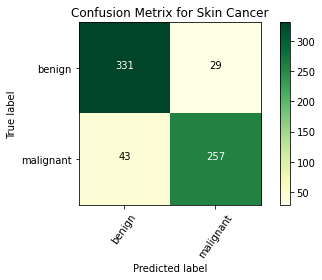

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[336  24]
 [ 53 247]]


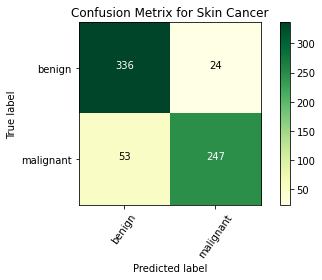

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       360
           1       0.91      0.82      0.87       300

    accuracy                           0.88       660
   macro avg       0.89      0.88      0.88       660
weighted avg       0.89      0.88      0.88       660



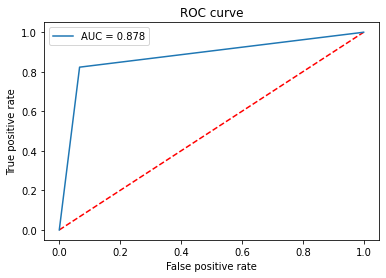

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

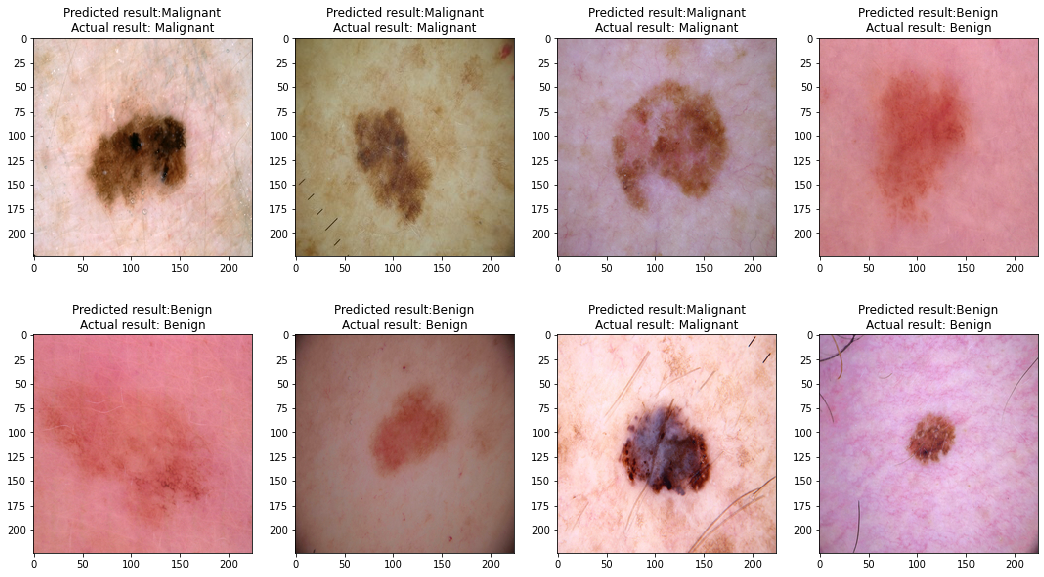

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()